Starting to load images...
Loaded 3500 images from Normal
Loaded 700 images from Tuberculosis
Total images loaded: 4200


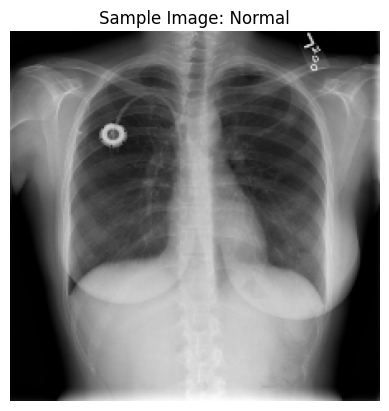

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


#uses 224x224 pixel images
IMG_SIZE = 224
DATA_DIR = "dataset"
CATEGORIES = ["Normal", "Tuberculosis"]

training_data = []

def create_training_data():
    print("Starting to load images...")
    for category in CATEGORIES:
        path = os.path.join(DATA_DIR, category)
        # Label 0 for Normal, 1 for Tuberculosis 
        class_num = CATEGORIES.index(category)
        
        # Check if folder exists to avoid errors
        if not os.path.exists(path):
            print(f"Error: Folder {path} not found!")
            continue

        count = 0
        for img in os.listdir(path):
            try:
                # Read image in Grayscale 
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                
                # Resize to 224x224 [cite: 157]
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                
                # Add to our list
                training_data.append([new_array, class_num])
                count += 1
            except Exception as e:
                pass
        print(f"Loaded {count} images from {category}")

create_training_data()

# Shuffle the data (important so the model doesn't learn order)
import random
random.shuffle(training_data)

print(f"Total images loaded: {len(training_data)}")

# --- VISUALIZATION CHECK ---
# Let's verify what we loaded by showing one random image
X_sample = training_data[0][0]
y_sample = training_data[0][1]
label_name = CATEGORIES[y_sample]

plt.imshow(X_sample, cmap='gray')
plt.title(f"Sample Image: {label_name}")
plt.axis('off')
plt.show()

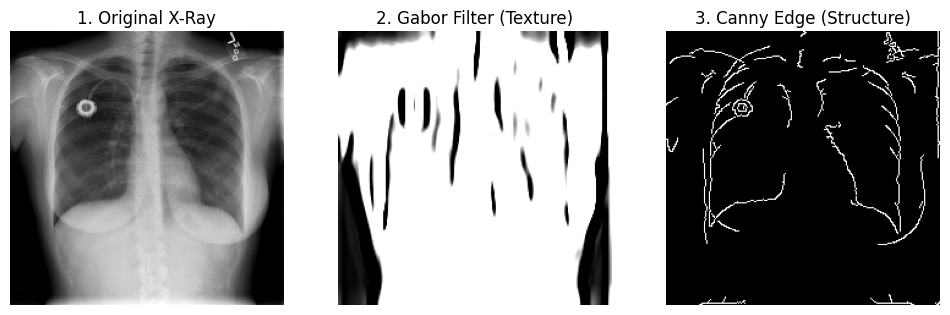

In [2]:
# --- STEP 3: DEFINE & TEST FILTERS ---

def apply_gabor(image):
    # Create the filter
    # ksize=31, sigma=4.0, theta=0, lambda=10.0, gamma=0.5
    g_kernel = cv2.getGaborKernel((31, 31), 4.0, 0, 10.0, 0.5, 0, ktype=cv2.CV_32F)
    
    # Apply the filter to the image
    filtered_img = cv2.filter2D(image, cv2.CV_8UC3, g_kernel)
    return filtered_img

def apply_canny(image):
    # Apply Canny edge detection (thresholds 100 and 200)
    edges = cv2.Canny(image, 100, 200)
    return edges

# Get one sample image to test
sample_img = training_data[0][0]

# Apply the filters
gabor_img = apply_gabor(sample_img)
canny_img = apply_canny(sample_img)

# Show them side-by-side
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(sample_img, cmap='gray')
plt.title("1. Original X-Ray")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gabor_img, cmap='gray')
plt.title("2. Gabor Filter (Texture)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(canny_img, cmap='gray')
plt.title("3. Canny Edge (Structure)")
plt.axis('off')

plt.show()

In [3]:
# --- STEP 4: PREPARE THE FINAL DATASET ---

X = [] # Features (The images)
y = [] # Labels (0 or 1)

print("Processing all images with Hybrid Filters...")

for features, label in training_data:
    # 1. Original Image (already 224x224)
    img = features
    
    # 2. Apply Gabor Filter
    gabor = apply_gabor(img)
    
    # 3. Apply Canny Edge Detection
    canny = apply_canny(img)
    
    # 4. Stack them into a 3-channel image (like RGB)
    # The shape becomes (224, 224, 3)
    combined_img = np.dstack((img, gabor, canny))
    
    X.append(combined_img)
    y.append(label)

# Convert lists to NumPy arrays (needed for AI training)
X = np.array(X).astype('float32')
y = np.array(y)

# --- NORMALIZE THE DATA ---
# Pixel value re-scaling between 0 and 1
# This makes training faster and more accurate.
X = X / 255.0

print("Done!")
print(f"Final Data Shape: {X.shape}") 
# Expected: (4200, 224, 224, 3)

Processing all images with Hybrid Filters...
Done!
Final Data Shape: (4200, 224, 224, 3)


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# --- 1. SPLIT THE DATA ---
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# --- 2. BUILD THE MODEL (MobileNetV2) ---
# We load MobileNetV2 but cut off the "top" (the classification head)
# because we want to add our own TB-specific layers.
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model so we don't destroy pre-learned features
base_model.trainable = False 

# Add our custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) # A dense layer for thinking
x = Dropout(0.2)(x)                  # Dropout helps prevent overfitting
predictions = Dense(1, activation='sigmoid')(x) # Output: 0 (Normal) to 1 (TB)

# Combine them into the final model
model = Model(inputs=base_model.input, outputs=predictions)

# --- 3. COMPILE THE MODEL ---
# Adam optimizer and Cross-Entropy loss
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Model built successfully!")
model.summary()

Splitting data...
Training samples: 3360
Testing samples: 840
Model built successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Starting training (10 Epochs)...
Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8961 - loss: 0.2894 - val_accuracy: 0.9345 - val_loss: 0.1783
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9494 - loss: 0.1535 - val_accuracy: 0.9512 - val_loss: 0.1317
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9604 - loss: 0.1211 - val_accuracy: 0.9631 - val_loss: 0.1131
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 103s 979ms/step - accuracy: 0.9711 - loss: 0.1004 - val_accuracy: 0.9655 - val_loss: 0.0948
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9711 - loss: 0.0896 - val_accuracy: 0.9690 - val_loss: 0.0868
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9789 - loss: 0.0799 - val_accuracy: 0.9702 - val_loss: 0.0827
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 105s 1000ms/step - accuracy: 0.9789 - loss: 0.0718 - val_accuracy: 0.9690 - val_loss: 0.0782
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 101s 966ms/step -

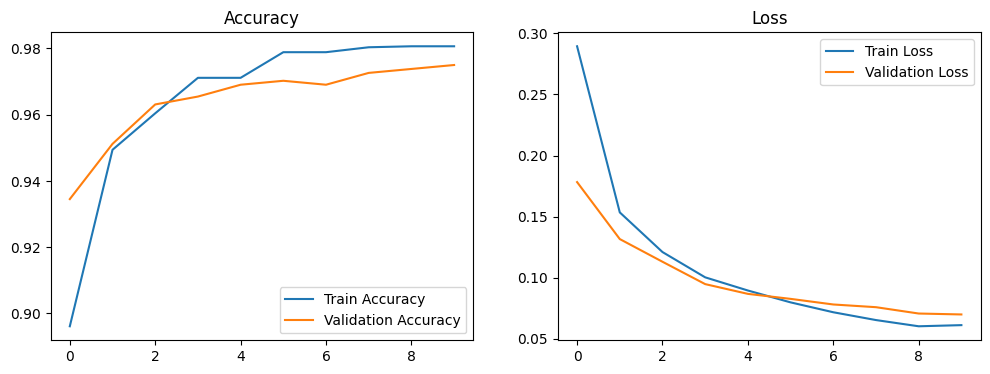

In [5]:
# --- STEP 6: TRAIN THE MODEL ---
print("Starting training (10 Epochs)...")

# This starts the learning process
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(X_test, y_test))

print("Training finished!")

# --- PLOT THE RESULTS ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [7]:
# --- STEP 8: SAVE THE MODEL ---
model.save('tb_detection_hybrid_model.h5')
print("Model saved successfully as 'tb_detection_hybrid_model.h5'")

Model saved successfully as 'tb_detection_hybrid_model.h5'


In [8]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Create the Upload Button
uploader = widgets.FileUpload(
    accept='.jpg, .png, .jpeg',  # Accept standard image formats
    multiple=False  # One file at a time
)

# 2. Define the logic (What happens when you upload)
def on_upload_change(change):
    if not uploader.value:
        return
    
    # Get the file data from the uploader
    # (The structure varies slightly by Jupyter version, this handles the common way)
    try:
        uploaded_file = list(uploader.value.values())[0]
        content = uploaded_file['content']
    except Exception:
        # Fallback for different widget versions
        uploaded_file = uploader.value[0]
        content = uploaded_file.content.tobytes()

    # Convert bytes to an Image (OpenCV format)
    nparr = np.frombuffer(content, np.uint8)
    img_array = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    
    # --- PROCESSING (Same as before) ---
    resized_img = cv2.resize(img_array, (224, 224))
    
    # Apply Filters
    gabor = apply_gabor(resized_img)
    canny = apply_canny(resized_img)
    combined_img = np.dstack((resized_img, gabor, canny))
    
    # Prepare for Model
    final_input = combined_img.astype('float32') / 255.0
    final_input = np.expand_dims(final_input, axis=0)
    
    # Predict
    prediction_score = model.predict(final_input)[0][0]
    
    # --- DISPLAY RESULTS ---
    clear_output() # Clear the previous result
    display(uploader) # Keep the button visible
    
    if prediction_score > 0.5:
        result_text = f"TUBERCULOSIS DETECTED\nConfidence: {prediction_score*100:.2f}%"
        color = 'red'
    else:
        result_text = f"NORMAL (Healthy)\nConfidence: {(1-prediction_score)*100:.2f}%"
        color = 'green'

    plt.figure(figsize=(6, 6))
    plt.imshow(resized_img, cmap='gray')
    plt.title(result_text, color=color, fontweight='bold', fontsize=14)
    plt.axis('off')
    plt.show()
# 3. Activate the button
uploader.observe(on_upload_change, names='value')

print("Click the button below to diagnose an X-ray:")
display(uploader)

Click the button below to diagnose an X-ray:


FileUpload(value=(), accept='.jpg, .png, .jpeg', description='Upload')

In [9]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Create the widgets
uploader = widgets.FileUpload(
    accept='.jpg, .png, .jpeg',
    multiple=False
)
# This output box will catch any silent errors
output_box = widgets.Output()

display(widgets.Label("1. Upload an X-ray image:"))
display(uploader)
display(output_box)

def on_upload_change(change):
    # This logic forces all errors to print inside the box
    with output_box:
        clear_output()
        print("Image received! Starting processing...")
        
        try:
            # --- 1. GET DATA (Compatible with different Jupyter versions) ---
            if not uploader.value:
                print("No file found in uploader.")
                return

            # Check structure of the uploaded data (Debugging step)
            vals = uploader.value
            
            # Handling different ipywidgets versions (v7 vs v8)
            content = None
            if isinstance(vals, dict): 
                # Version 7 style
                first_key = list(vals.keys())[0]
                content = vals[first_key]['content']
            elif isinstance(vals, tuple):
                # Version 8 style
                content = vals[0]['content']
            else:
                # Fallback
                print(f"Unknown widget data type: {type(vals)}")
                # Try accessing as list/dict values
                try:
                    content = list(vals.values())[0]['content']
                except:
                    pass

            if content is None:
                print("Error: Could not extract file content. Try uploading again.")
                return

            print("Decoding image...")
            # Convert bytes to Image
            nparr = np.frombuffer(content, np.uint8)
            img_array = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
            
            if img_array is None:
                print("Error: The file is not a valid image. Please try a .jpg or .png")
                return

            # --- 2. PROCESSING ---
            print("Applying Hybrid Filters...")
            resized_img = cv2.resize(img_array, (224, 224))
            
            # Apply your filters (Ensure these functions exist from previous cells!)
            gabor = apply_gabor(resized_img)
            canny = apply_canny(resized_img)
            combined_img = np.dstack((resized_img, gabor, canny))
            
            # Normalize
            final_input = combined_img.astype('float32') / 255.0
            final_input = np.expand_dims(final_input, axis=0)
            
            # --- 3. PREDICT ---
            print("Asking AI for diagnosis...")
            prediction_score = model.predict(final_input)[0][0]
            
            # --- 4. SHOW RESULT ---
            if prediction_score > 0.5:
                result_text = f"TUBERCULOSIS DETECTED\nConfidence: {prediction_score*100:.2f}%"
                color = 'red'
            else:
                result_text = f"NORMAL (Healthy)\nConfidence: {(1-prediction_score)*100:.2f}%"
                color = 'green'

            plt.figure(figsize=(6, 6))
            plt.imshow(resized_img, cmap='gray')
            plt.title(result_text, color=color, fontweight='bold', fontsize=14)
            plt.axis('off')
            plt.show()
            print("Done!")

        except Exception as e:
            print("An error occurred!")
            print(e)

# Connect the observer
uploader.observe(on_upload_change, names='value')

Label(value='1. Upload an X-ray image:')

FileUpload(value=(), accept='.jpg, .png, .jpeg', description='Upload')

Output()

In [10]:
model.save('tb_detection_hybrid_model.h5')